In [12]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

import datetime, time, os, sys

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [7]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [8]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36319/status,
Dashboard: /proxy/36319/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45601,Workers: 4
Dashboard: /proxy/36319/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.122.41:43835,Total threads: 4
Dashboard: /proxy/33293/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46083,


In [9]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_nostress.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_vary_KPP.db'
session_varyKPP = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_param_KPP', '1deg_jra55_ryf_nostress', '1deg_jra55_ryf_vary_KPP']
session = [session_cont, session_cont, session_varyKPP]
name = ['Control', 'Nostress', 'Vary_KPP']

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


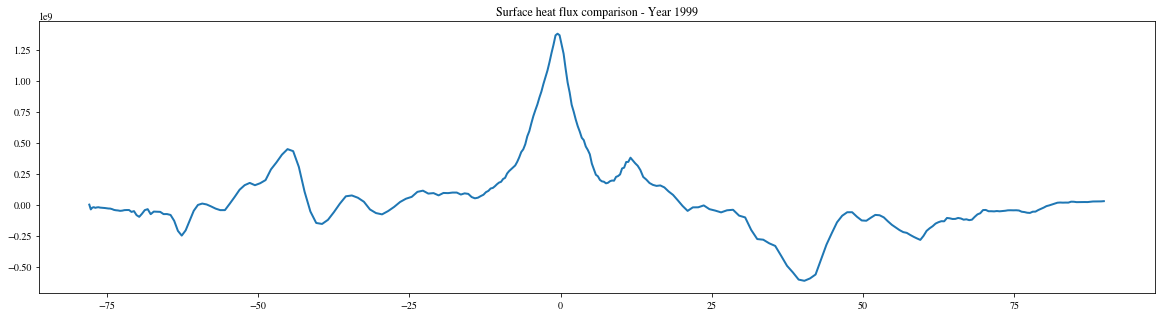

In [38]:
nframes = 100
startframe = 1
frames_plot = []
fig = plt.figure(1,figsize=(20, 5))
nt = 1

var_list = ['swflx', 'lw_heat', 'evap_heat', 'sens_heat']

dxt = cc.querying.getvar(expt = expt[0], variable = 'dxt', session = session[0], frequency = 'static', n = 1)
lat = dxt.yt_ocean

def updatefig(nt):
#for nt in range(0,nframes):
    plt.clf()
    currentframe = startframe + nt
    year = 1900 + nt
    #day = np.mod(currentframe-1,365)+1
    
    d = np.floor((year - 1900)/5)
    if d <= 9:
        dir = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_vary_KPP/output00%d/ocean' % d
    else:
        dir = '/scratch/x77/db6174/access-om2/archive/1deg_jra55_ryf_vary_KPP/output0%d/ocean' % d
    
    sum_var = 0
    
    iter = ['ocean-2d-swflx-1-monthly-mean-ym_%4d_01.nc' % (year), 
        'ocean-2d-lw_heat-1-monthly-mean-ym_%4d_01.nc' % (year),
        'ocean-2d-evap_heat-1-monthly-mean-ym_%4d_01.nc' % (year),
        'ocean-2d-sens_heat-1-monthly-mean-ym_%4d_01.nc' % (year)]
    
    file = os.path.join(dir, iter[0])
    data = xr.open_dataset(file)
    var = (data.swflx * dxt).sum(dim = ['xt_ocean']).mean('time')
    sum_var = sum_var + var
    
    file = os.path.join(dir, iter[1])
    data = xr.open_dataset(file)
    var = (data.lw_heat * dxt).sum(dim = ['xt_ocean']).mean('time')
    sum_var = sum_var + var
    
    file = os.path.join(dir, iter[2])
    data = xr.open_dataset(file)
    var = (data.evap_heat * dxt).sum(dim = ['xt_ocean']).mean('time')
    sum_var = sum_var + var
    
    file = os.path.join(dir, iter[3])
    data = xr.open_dataset(file)
    var = (data.sens_heat * dxt).sum(dim = ['xt_ocean']).mean('time')
    sum_var = sum_var + var
        
    fig = plt.figure(1,figsize=(20, 5))
    p1 = plt.plot(lat, sum_var)
    plt.title('Surface heat flux comparison - Year %4d' % year)
    
    filestr = '/home/156/db6174/x77/1deg_test_runs/Vary_KPP/Animations/Sfc_hflux/Figures/image%04d.png' % nt
    plt.savefig(filestr, dpi = 300)
    print(nt)        
    return p1
    
anim = animation.FuncAnimation(fig, updatefig, frames=nframes, interval=1, blit=False)
metadata = dict(title='Zonally avgd sfc hflux', artist='GFD ANU',comment='Animation made using matplotlib and ffmpeg')
ffwriter = animation.FFMpegWriter(fps=8, codec='libx264', bitrate=4000, extra_args=['-pix_fmt','yuv420p'], metadata=metadata)
anim.save('Animations/Zonal_hflux.m4v', writer=ffwriter)

plt.show()